In [1]:
%matplotlib inline
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from classy import Class
from matplotlib.lines import Line2D
from smt.sampling_methods import LHS
from matplotlib.pyplot import cm
from uqpylab import sessions
from scipy.interpolate import interp1d
from scipy.spatial.distance import pdist
import statistics as st
import os, sys, warnings
from configparser import ConfigParser
from itertools import chain
import math
import seaborn as sns
from collections import defaultdict


def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data_kgb = nested_dict(5, list)



import os

# Where to save the figures

IMAGES_PATH = './images'
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=180):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

In [2]:
## works
path = "/home/ahmad/Desktop/cluster/Spectra_gevoution_kevolution/gevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em7_05062020/output"



data_DE = np.loadtxt(path+'/w0d9_cs2_em7_gevolution_pk016_deltaclass.dat')
kk_sim = data_DE[:, 0]
pk_DE = data_DE[:, 1]
norm = (2 * (np.pi) ** 2) / ((kk_sim) ** 3)
pk_sim_DE = norm * pk_DE


data_m = np.loadtxt(path+'/w0d9_cs2_em7_gevolution_pk016_delta.dat')
kk_sim = data_m[:, 0]
pk_m = data_m[:, 1]
pk_sim_m = norm * pk_m



path_gev = "/home/ahmad/Desktop/cluster/Spectra_gevoution_kevolution/kevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em7_05062020/output"
data_DE_kev = np.loadtxt(path+'/w0d9_cs2_em7_gevolution_pk016_deltaclass.dat')
pk_DE_kev = data_DE_kev[:, 1]
pk_sim_DE_kev = norm * pk_DE_kev

In [3]:
from configparser import ConfigParser
from itertools import chain

############################################################################################################ 
#                                               data path

#folder_name_kgb = '/home/ahmad/kgb-master/output'
folder_name_kgb = '/home/ahmad/kgb-master/data/512-1500Mpc-ak=3e6ab=0.4/'
#folder_name_kgb = '/home/ahmad/kgb-master/data/2048-800/'


############################################################################################################ 
#                                              background file


with open(f"{folder_name_kgb}/file_background.dat") as f:
    lines = f.readlines()

fourpiG_val = float(next(line.split("=")[1].strip() for line in lines if line.startswith("# fourpiG")))
H0_val = float(next(line.split("=")[1].strip() for line in lines if line.startswith("# H0[1/Mpc]")))

norm_kgb = np.sqrt(2*fourpiG_val/3)/H0_val

bg_kgb = np.loadtxt(f"{folder_name_kgb}/file_background.dat")

# scale factor and redshift
a_kgb = bg_kgb[:,2]
z_kgb = bg_kgb[:,3]

# z_kgb = [0 if x < 0 else x for x in z_kgb]
# z_kgb[-2], z_kgb[-1] = 0.01, 0


# Conformal Hubble parameter and its derivative 
Hconf_kgb = bg_kgb[:,5]
Hconf_prime_kgb = bg_kgb[:,6]
Hconf_prime_prime_kgb = bg_kgb[:,7]


# alpha parameters and their derivatives
alpha_K_kgb = bg_kgb[:,17]
alpha_B_kgb = bg_kgb[:,18]
alpha_K_prime_kgb = bg_kgb[:,19]
alpha_B_prime_kgb = bg_kgb[:,20]

# dark energy density and pressure and their derivatives
rho_smg_kgb = bg_kgb[:,13]
p_smg_kgb = bg_kgb[:,14]
rho_smg_prime_kgb = bg_kgb[:,15]
p_smg_prime_kgb = bg_kgb[:,16]
cs2_kgb = bg_kgb[:,21]

H_hiclass =  bg_kgb[:,4]

# other background values
rho_cdm_kgb = bg_kgb[:,8]
rho_b_kgb = bg_kgb[:,9]

############################################################################################################ 
#                                         hiclass ini parameters

parser = ConfigParser()
with open(f"{folder_name_kgb}/file_classparameters.ini") as lines:
    lines = chain(("[top]",), lines) # This line produce a fake section header called top
    parser.read_file(lines)

Omega_fld = float(parser.get("top", "Omega_fld"))
Omega_b = float(parser.get("top", "Omega_b"))
Omega_cdm = float(parser.get("top", "Omega_cdm"))

# Extract and parse the 'parameters_smg' string
expansion_smg_str = parser.get("top", "expansion_smg")
expansion_smg_list = expansion_smg_str.split(',')
Omega_kgb = float(expansion_smg_list[0].strip())

############################################################################################################ 
#                                   KGB-evolution used.ini parameters

with open(f"{folder_name_kgb}/file_settings_used.ini") as lines:
    lines = chain(("[top]",), lines) # This line produce a fake section header called top
    parser.read_file(lines)

k_pivot = float(parser.get("top", "k_pivot"))     
A_s = float(parser.get("top", "A_s"))   
n_s = float(parser.get("top", "n_s"))
h = float(parser.get("top", "h"))

omega_b = float(parser.get("top", "omega_b"))
omega_cdm = float(parser.get("top", "omega_cdm"))


gravity_model = (parser.get("top", "gravity_model"))
    
# Extract and parse the 'parameters_smg' string
parameters_smg_str = parser.get("top", "parameters_smg")
parameters_smg_list = parameters_smg_str.split(',')
    
# Convert the first two parameters to floats
alpha_K_hat = float(parameters_smg_list[0].strip())
alpha_B_hat = float(parameters_smg_list[1].strip())    



# Function to format numbers for LaTeX (reusing the previous function)
def format_scientific_latex(number):
    mantissa, exponent = f"{number:.1e}".split('e')
    exponent = exponent.lstrip('+').lstrip('0') or '0'
    return f"{mantissa} \\times 10^{{{exponent}}}"

# Format the alpha values
alpha_K_hat_latex = format_scientific_latex(alpha_K_hat)

# Extract and parse the 'parameters_smg' string
expansion_smg_str = parser.get("top", "expansion_smg")
expansion_smg_list = expansion_smg_str.split(',')

w_kgb = float(expansion_smg_list[0].strip())
w_a_kgb = float(expansion_smg_list[1].strip())

boxsize = float(parser.get("top", "boxsize"))
Ngrid = float(parser.get("top", "Ngrid"))

boxsize = int(boxsize)
Ngrid = int(Ngrid)

# z_snap = float(parser.get("top", "snapshot redshifts"))
# a_snap = 1/(1+z_snap)

k_nyq = np.pi*Ngrid/boxsize
dx = boxsize/Ngrid

n_kgb_numsteps   = float(parser.get("top", "n_kgb_numsteps"))
Courant_factor = float(parser.get("top", "Courant factor"))


Omega_Lambda = float(parser.get("top", "Omega_Lambda"))

# reading Pk the redshifts
z = []

with open(f'{folder_name_kgb}/file_settings_used.ini', 'r') as f:
    for line in f:
        if line.startswith('Pk redshifts'):
            # Extract the part after '=' and split by commas
            redshifts_string = line.split('=')[1].split('#')[0].strip()  # Remove comments after #
            z = [float(x.strip()) for x in redshifts_string.split(',')]  # Parse as floats

redshifts = z

colors_plot = sns.color_palette("inferno", len(z)).as_hex()


delta_rho_kgb = [None] * len(z)
mu = [None] * len(z)
mu_corr =[None] * len(z)

pk_phi_kgb = [None] * len(z)
pk_phi_prime_kgb = [None] * len(z)

pk_matter_kgb = [None] * len(z)
pk_pi_kgb = [None] * len(z)
pk_zeta_kgb = [None] * len(z)

f_rho_fld = interp1d(z_kgb, rho_smg_kgb, kind='linear')
f_rho_cdm = interp1d(z_kgb, rho_cdm_kgb, kind='linear')
f_rho_b = interp1d(z_kgb, rho_b_kgb, kind='linear')


def rho_m_kgb_f(val):
    return f_rho_cdm(val) + f_rho_b(val)

def rho_smg_kgb_f(val):
    return f_rho_fld(val)

for zind, zval in list(enumerate(z)):
    
    file_index = str(zind).zfill(2)
    
    data_kgb["kgb"]["delta_kgb"]["z=" + str(z[zind])] = np.loadtxt(
        f"{folder_name_kgb}/pk_0{file_index}_delta_kgb.dat"
    )
    data_kgb["kgb"]["delta"]["z=" + str(z[zind])] = np.loadtxt(
        f"{folder_name_kgb}/pk_0{file_index}_delta.dat"
    )
    
    data_kgb["kgb"]["phi"]["z=" + str(z[zind])] = np.loadtxt(
        f"{folder_name_kgb}/pk_0{file_index}_phi.dat"
    )
    
    data_kgb["kgb"]["phi_prime"]["z=" + str(z[zind])] = np.loadtxt(
        f"{folder_name_kgb}/pk_0{file_index}_phi_prime.dat"
    )
    
    data_kgb["kgb"]["pi"]["z=" + str(z[zind])] = np.loadtxt(
        f"{folder_name_kgb}/pk_0{file_index}_pi_k.dat"
    )
    
    data_kgb["kgb"]["zeta"]["z=" + str(z[zind])] = np.loadtxt(
        f"{folder_name_kgb}/pk_0{file_index}_zeta.dat"
    )
    data_kgb["kgb"]["deltakgb_deltam"]["z=" + str(z[zind])] = np.loadtxt(
        f"{folder_name_kgb}/pk_0{file_index}_deltakgb_deltam.dat"
    )
    
    k = data_kgb["kgb"]["delta_kgb"]["z=" + str(z[zind])][:, 0]
    
    pk_kgb_delta_kgb = data_kgb["kgb"]["delta_kgb"]["z=" + str(z[zind])][:, 1]

    pk_kgb_delta = data_kgb["kgb"]["delta"]["z=" + str(z[zind])][:, 1]
    
    pk_kgb_phi = data_kgb["kgb"]["phi"]["z=" + str(z[zind])][:, 1]
    
    pk_kgb_phi_prime = data_kgb["kgb"]["phi_prime"]["z=" + str(z[zind])][:, 1]
    
    pk_kgb_pi = data_kgb["kgb"]["pi"]["z=" + str(z[zind])][:, 1]
    
    pk_kgb_zeta = data_kgb["kgb"]["zeta"]["z=" + str(z[zind])][:, 1]
    
    pk_kgb_deltakgb_deltam = data_kgb["kgb"]["deltakgb_deltam"]["z=" + str(z[zind])][:, 1]
    
    norm_s = (2*(np.pi)**2)/((k)**3)
    
    delta_rho_kgb[zind] = pk_kgb_delta_kgb 
    pk_phi_kgb[zind] = pk_kgb_phi
    pk_phi_prime_kgb[zind] = pk_kgb_phi_prime
    pk_matter_kgb[zind] = pk_kgb_delta
    
    pk_pi_kgb[zind] = pk_kgb_pi
    pk_zeta_kgb[zind] = pk_kgb_zeta
    
    
    
    
    mu[zind] = 1 + (rho_smg_kgb_f(zval)*np.sqrt(pk_kgb_delta_kgb))/(rho_m_kgb_f(zval)*np.sqrt(pk_kgb_delta))
    mu_corr[zind] = np.sqrt(
    ((rho_smg_kgb_f(zval) ** 2) * pk_kgb_delta_kgb + (rho_m_kgb_f(zval) ** 2) * pk_kgb_delta
        + 2 * (rho_m_kgb_f(zval) * rho_smg_kgb_f(zval)) * pk_kgb_deltakgb_deltam)
    / ((rho_m_kgb_f(zval) ** 2) * pk_kgb_delta)
    )
    #kk_kgb = k
    
    ind_nyq       = [i for i, v in enumerate(k) if k_nyq*0.75 < v ][0]
    #ind_nyq =-1
    kk_kgb        = k[:ind_nyq]
    
    mu[zind]      = mu[zind][:ind_nyq]
    delta_rho_kgb[zind]  =  delta_rho_kgb[zind][:ind_nyq]
    
    pk_phi_kgb[zind] = pk_phi_kgb[zind][:ind_nyq]
    pk_phi_prime_kgb[zind] = pk_phi_prime_kgb[zind][:ind_nyq]
    pk_matter_kgb[zind] =pk_matter_kgb[zind][:ind_nyq]
    pk_pi_kgb[zind] =  pk_pi_kgb[zind][:ind_nyq]
    pk_zeta_kgb[zind] = pk_zeta_kgb[zind][:ind_nyq]
    
    mu_corr[zind] = mu_corr[zind][:ind_nyq]

In [4]:
alpha_K_hat = 3e+06
alpha_B_hat = 0
#z = [100.0, 15.0, 10.0, 8.0, 5.0, 2.0, 1.0, 0.5, 0]
z = [0]

In [5]:
def a(x):
    return 1 / (1 + x)

Pk_LCDM = [[] for j in range(len(z))]
#kk = np.logspace(-3.2, np.log10(10), 1000)  # k in h/Mpc
kk = kk_sim

# synchronous = {
#     "Omega_smg": -1,
#     "Omega_Lambda": 0,
#     "Omega_fld": 0,
#     "h": h,
#     "Omega_b": Omega_b,
#     "Omega_cdm": Omega_cdm,
#     "A_s": A_s,
#     "n_s": n_s,
#     "z_max_pk": 100,
#     "tau_reio": 0.05430842,
#     "gravity_model": gravity_model,
#     "parameters_smg": f"{alpha_K_hat}, {alpha_B_hat}, 0, 0, 1",
#     "expansion_model": "w0wa",
#     "expansion_smg": f"{Omega_kgb},{w_kgb},{w_a_kgb}",
#     "extra metric transfer functions": "yes",
#     "output_background_smg": 10,
#     "output": "dTk,vTk,mPk",
#     "skip_stability_tests_smg": "n",
#     "P_k_max_1/Mpc": 130,
# }




synchronous ={
        "Omega_smg": -1,
        "Omega_Lambda": 0,
        "Omega_fld": 0,
        "parameters_smg": f"{alpha_K_hat}, {alpha_B_hat}, 0, 0, 1",
        "expansion_model": "w0wa",
        "expansion_smg": f"0.6795289,-0.9,0",
        "gravity_model": gravity_model,
        "extra metric transfer functions": "yes",
        "h": 0.67,
        "omega_b":  0.021996,
        "omega_cdm": 0.121203,
        "A_s": 2.1e-9,
        "n_s": 0.96,
        "z_max_pk": 100,
        "tau_reio": 0.05430842,
        "N_ur": 1.0196,
        "N_ncdm":2,
        "non linear":"Halofit",
        "m_ncdm": f"0.00868907, 0.05",
        "output": "dTk,vTk,mPk",
        "output_background_smg": 10,
        "skip_stability_tests_smg": "n",
        "P_k_max_1/Mpc": 192,
    }

M_syn = Class()
M_syn.set(synchronous)

M_syn.compute()

backgrounds = M_syn.get_background()

rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")
H_prime_prime = interp1d(backgrounds["z"], backgrounds["H_prime_prime"], kind="cubic")

rho_smg = interp1d(backgrounds["z"], backgrounds["(.)rho_smg"], kind="cubic")
p_smg = interp1d(backgrounds["z"], backgrounds["(.)p_smg"], kind="cubic")

rho_smg_prime = interp1d(
    backgrounds["z"], backgrounds["(.)rho_smg_prime"], kind="cubic"
)
p_smg_prime = interp1d(backgrounds["z"], backgrounds["(.)p_smg_prime"], kind="cubic")

alpha_K = interp1d(backgrounds["z"], backgrounds["kineticity_smg"], kind="cubic")
alpha_B = interp1d(backgrounds["z"], backgrounds["braiding_smg"], kind="cubic")

alpha_K_prime = interp1d(
    backgrounds["z"], backgrounds["kineticity_prime_smg"], kind="cubic"
)
alpha_B_prime = interp1d(
    backgrounds["z"], backgrounds["braiding_prime_smg"], kind="cubic"
)

a_hi = 1.0 / (1.0 + backgrounds["z"])
a_hiclass = interp1d(backgrounds["z"], a_hi, kind="cubic")
z_hi = backgrounds["z"]

Hconf_hi = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"] * a_hi)
Hconf_prime_hi = interp1d(
    backgrounds["z"],
    (a_hi**2) * (backgrounds["H [1/Mpc]"] ** 2) + a_hi * backgrounds["H_prime"],
)

H0 = Hconf_hi(0)
Mpl2 = 1 / (3.0 * H0**2)


# conformal huble time in terms of physical huble time (3rd formula)
Hconf_hiclass = norm_kgb * H(z_kgb) * a_hiclass(z_kgb)

Hconf_prime_hiclass = (norm_kgb**2) * (a_hiclass(z_kgb) ** 2) * ((H(z_kgb) ** 2)) + (
    norm_kgb**2
) * a_hiclass(z_kgb) * H_prime(z_kgb)

Hconf_prime_prime_hiclass = (
    2 * (a_hiclass(z_kgb) ** 3) * (H(z_kgb) ** 3)
    + 3 * (a_hiclass(z_kgb) ** 2) * H(z_kgb) * H_prime(z_kgb)
    + a_hiclass(z_kgb) * H_prime_prime(z_kgb)
) * norm_kgb**3


Normalization = A_s * (kk / k_pivot) ** (n_s - 1.0)


##################################################
#                                                #
#        for pi and zeta calculation             #
#                                                #
##################################################

pk_pi_hi = [None] * len(z)
pk_pi_prime_hi = [None] * len(z)
pk_zeta_hi = [None] * len(z)

##################################################
#                                                #
#               for mu calculation               #
#                                                #
##################################################

mu_kgb_phi = [[] for j in range(len(z))]
mu_kgb_delta = [[] for j in range(len(z))]


pk_phi_hi = [None] * len(z)
pk_phi_prime_hi = [None] * len(z)
pk_matter_hi = [None] * len(z)

delta_smg_hi = [None] * len(z)
delta_smg_hi_phi = [None] * len(z)

pk_delta_smg_hi = [None] * len(z)

for zind, z_val in enumerate(z):

    Transfers_syn = M_syn.get_transfer(z_val)

    kk_hi = Transfers_syn["k (h/Mpc)"]

    #############
    delta_b_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_b"], kind="cubic"
    )
    theta_b_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_b"], kind="cubic"
    )
    #############
    #                         theta_cdm is zero in synchronous gauge
    delta_cdm_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_cdm"], kind="cubic"
    )
    #############
    delta_g_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_g"], kind="cubic"
    )
    theta_g_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_g"], kind="cubic"
    )
    #############
    delta_ur_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_ur"], kind="cubic"
    )
    theta_ur_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_ur"], kind="cubic"
    )
    #############

    delta_tot_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_tot"], kind="cubic"
    )

    theta_tot_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_tot"], kind="cubic"
    )

    phi_syn = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["phi"], kind="cubic")

    phi_prime_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["phi_prime"], kind="cubic"
    )
    psi_syn = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["psi"], kind="cubic")

    vx_smg = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["vx_smg"], kind="cubic")

    vx_prime_smg = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["vx_prime_smg"], kind="cubic"
    )
    eta = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["eta"], kind="cubic")

    eta_prime = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["eta_prime"], kind="cubic"
    )

    h_met = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["h"], kind="cubic")

    h_prime_met = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["h_prime"], kind="cubic"
    )

    #####################################################################################################
    #                                 constructing pi and zeta in hiclass

    alpha = (h_prime_met(kk) + 6.0 * eta_prime(kk)) / (2.0 * kk * kk * h * h)
    pi_hi = -vx_smg(kk) + alpha

    alpha_prime = psi_syn(kk) - Hconf_hi(z_val) * alpha
    pi_prime_hi = -vx_prime_smg(kk) + alpha_prime

    zeta_hi = pi_prime_hi + Hconf_hi(z_val) * pi_hi - psi_syn(kk)

    pk_pi_hi[zind] = Normalization * (pi_hi**2)
    pk_pi_prime_hi[zind] = Normalization * (pi_prime_hi**2)

    pk_zeta_hi[zind] = Normalization * (zeta_hi**2)

    #####################################################################################################
    #                                 constructing mu in hiclass

    delta_smg_tmp = []  # for storing delta_de fro KGB at each redshift
    delta_smg_phi_tmp = []

    phi_tmp = []
    phi_prime_tmp = []
    matter_tmp = []
    tmp_LCDM = []

    for k in kk:

        ###################################################################################################
        #                                 delta_smg in Newtonian

        alpha = (h_prime_met(k) + 6.0 * eta_prime(k)) / (2.0 * k * k * h * h)
        alpha_prime = psi_syn(k) - Hconf_hi(z_val) * alpha

        pi_newt = -vx_smg(k) + alpha
        pi_prime_newt = -vx_prime_smg(k) + alpha_prime
        zeta_newt = Hconf_hi(z_val) * pi_newt + pi_prime_newt - psi_syn(k)

        delta_smg_newt = (
            (Mpl2 / a(z_val) ** 2)
            * (
                -alpha_B(z_val) * Hconf_hi(z_val) * ((k * h) ** 2) * pi_newt
                + 3 * alpha_B(z_val) * (Hconf_hi(z_val) ** 2) * psi_syn(k)
                - (3 * alpha_B(z_val) + alpha_K(z_val))
                * (Hconf_hi(z_val) ** 2)
                * zeta_newt
                + 3 * alpha_B(z_val) * Hconf_hi(z_val) * phi_prime_syn(k)
            )
            + (
                (Mpl2 * alpha_B(z_val) / (a(z_val) ** 2))
                * (Hconf_prime_hi(z_val) - Hconf_hi(z_val) ** 2)
                + ((rho_smg(z_val) + p_smg(z_val)) / H0**2)
            )
            * 3
            * Hconf_hi(z_val)
            * pi_newt
        ) / (rho_smg(z_val) / H0**2)



        ###################################################################################################

        Delta_cdm_sync = delta_cdm_syn(k)-alpha*3 * a(z_val) * H(z_val) 

        Delta_b_sync = delta_b_syn(k) + 3 * a(z_val) * H(z_val) * theta_b_syn(k) / (
            (k * h) ** 2
        )

        delta_matter = (
            rho_b(z_val) * Delta_b_sync + rho_cdm(z_val) * Delta_cdm_sync
        ) / (rho_b(z_val) + rho_cdm(z_val))

        # delta transformation
        Delta_smg_comov = delta_smg_newt + alpha * rho_smg_prime(z_val) / rho_smg(z_val)  # original




        delta_smg_tmp.append(delta_smg_newt)
        phi_tmp.append(phi_syn(k))
        phi_prime_tmp.append(phi_prime_syn(k))
        matter_tmp.append(Delta_cdm_sync)

        Delta_g_sync = delta_g_syn(k) + 3 * a(z_val) * H(z_val) * (
            1 + 1 / 3
        ) * theta_g_syn(k) / ((k * h) ** 2)

        Delta_ur_sync = delta_ur_syn(k) + 3 * a(z_val) * H(z_val) * (
            1 + 1 / 3
        ) * theta_ur_syn(k) / ((k * h) ** 2)

        rho_X_Delta_X = (
            rho_cdm(z_val) * Delta_cdm_sync
            + rho_b(z_val) * Delta_b_sync
            + rho_g(z_val) * Delta_g_sync
            + rho_ur(z_val) * Delta_ur_sync
        )

        k2_phi = -((k * h) ** 2) * phi_syn(k)

        ################################################################################################
        #                                   Poisson equation

        mu_kgb_delta[zind].append(
            1 - (rho_smg(z_val) * Delta_smg_comov / (rho_X_Delta_X))
        )

        #         R = 3. * a(zi) * H(zi) * phi_prime_new(k) + 3. * ((a(zi) * H(zi))**2) * psi_new(k)
        mu_k = (k2_phi) / (1.5 * a(z_val) ** 2 * rho_X_Delta_X)

        mu_kgb_phi[zind].append(mu_k)

        delta_smg_phi_tmp.append(-1 * (mu_k - 1) * rho_X_Delta_X / rho_smg(z_val))
        
        
        tmp_LCDM.append(M_syn.pk(k * h, z_val) * h**3)

    Pk_LCDM[zind] = tmp_LCDM    
    pk_phi_prime_hi[zind] = (Normalization) * np.array(phi_prime_tmp) ** 2 / H0**2
    pk_phi_hi[zind] = (Normalization) * np.array(phi_tmp) ** 2
    pk_matter_hi[zind] = 2* (np.pi**2)/((kk)**3)*(Normalization) * np.array(matter_tmp) ** 2

    delta_smg_hi[zind] = delta_smg_tmp
    pk_delta_smg_hi[zind] = 2* (np.pi**2)/((kk_sim)**3) * (Normalization) * np.array(delta_smg_tmp) ** 2

    delta_smg_hi_phi[zind] = delta_smg_phi_tmp

In [6]:
Transfers_syn.keys()

dict_keys(['k (h/Mpc)', 'd_g', 'd_b', 'd_cdm', 'd_ur', 'd_ncdm[0]', 'd_ncdm[1]', 'vx_smg', 'vx_prime_smg', 'd_tot', 'phi', 'psi', 'phi_prime', 'h', 'h_prime', 'eta', 'eta_prime', 'H_T_Nb_prime', 'k2gamma_Nb', 't_g', 't_b', 't_ur', 't_ncdm[0]', 't_ncdm[1]', 't_tot'])

In [7]:
backgrounds.keys()

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'H_prime', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_ncdm[1]', '(.)p_ncdm[1]', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f', '(.)rho_smg', '(.)p_smg', '(.)rho_smg_prime', '(.)p_smg_prime', 'M*^2_smg', 'D_M*^2_smg', 'kineticity_smg', 'braiding_smg', 'tensor_excess_smg', 'Mpl_running_smg', 'c_s^2', 'c_s^2_prime', 'kin (D)', 'H_prime_prime', 'G_eff_smg', 'slip_eff_smg', 'kineticity_prime_smg', 'braiding_prime_smg', 'lambda_1', 'lambda_2', 'lambda_3', 'lambda_4', 'lambda_5', 'lambda_6', 'lambda_7', 'lambda_8', 'lambda_9', 'lambda_10', 'lambda_11', 'lambda_2_p', 'lambda_8_p', 'lambda_9_p', 'lambda_11_p', 'cs2num', 'cs2num_p'])

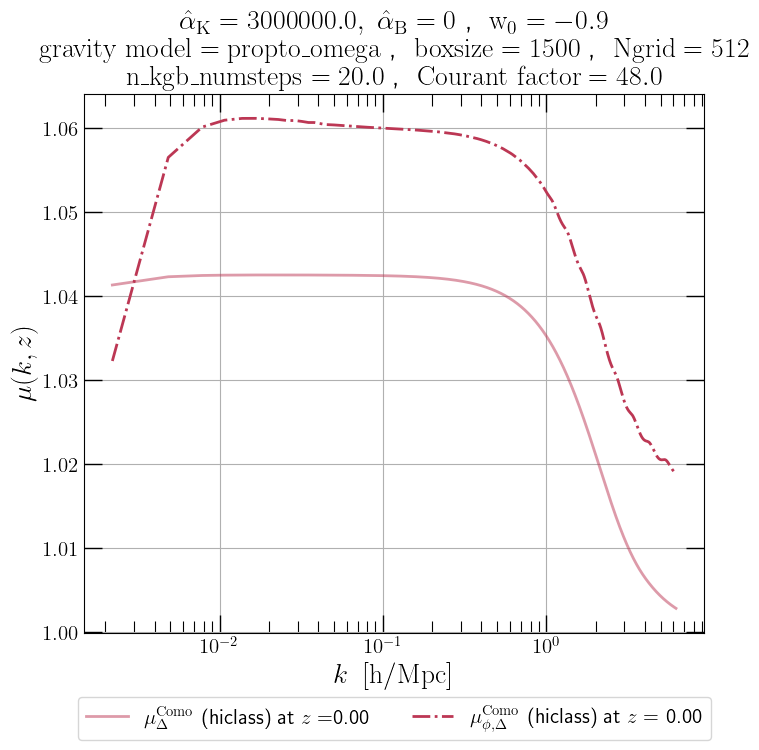

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(8, 7), sharex=True)
plt.subplots_adjust(hspace=0.012, wspace=0.23)

c = sns.color_palette("inferno", len(z)).as_hex()




################################################ plot ###########################################

for zind, zval in list(enumerate(z)):

    ###############################################################################################
    #                                        hiclass KGB

    axs.plot(
        kk,
        mu_kgb_delta[zind],
        linewidth=2.0,
        linestyle="-",
        c=c[zind],
        label="$\mu^\mathrm{Como}_{\Delta}$ (hiclass) at $z = $"
        + "{0:.2f}".format(zval),
        alpha=0.5,
    )

    axs.plot(
            kk,
            mu_kgb_phi[zind],
            linewidth=2.,
            linestyle="-.",
            c = c[zind],
            label="$\mu^\mathrm{Como}_{\phi,\Delta}$ (hiclass) at $z =$ " + "{0:.2f}".format(zval),
        )


# axs.axvline(x=0.7, color='r', linestyle='--', linewidth=2)
axs.set_ylabel(r"$\mu(k,z)$", fontsize=20)
axs.set_xlabel(r"$k\,\,\,  \mathrm{[h/Mpc]}$", fontsize=20)
# axs.axvline(x = 1.1, c = 'blue', linestyle = '--')


axs.tick_params("both", length=13, width=1, which="major")
axs.tick_params("both", length=8.5, width=0.8, which="minor")
axs.tick_params(direction="in", which="major", labelsize=15)
axs.tick_params(direction="in", which="minor")
axs.yaxis.set_ticks_position("both")
axs.xaxis.set_ticks_position("both")
axs.set_xscale("log")
# axs.set_yscale("log")

axs.grid()
# axs.legend(fontsize = 15)
axs.legend(
    fontsize=15,  # Font size
    loc="upper center",
    #bbox_to_anchor=(1.25, 1.02),
    bbox_to_anchor=(.5, -.1),
    ncol=2,
)


# axs.set_ylim(1.25,1.30)

gravity_model_latex = parser.get("top", "gravity_model")
gravity_model_latex = gravity_model.replace("_", r"\_")

axs.set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w_kgb}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model_latex}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    + "\n"
    + rf"$\mathrm{{n\_kgb\_numsteps}} = \mathrm{{{n_kgb_numsteps}}}$"
    + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

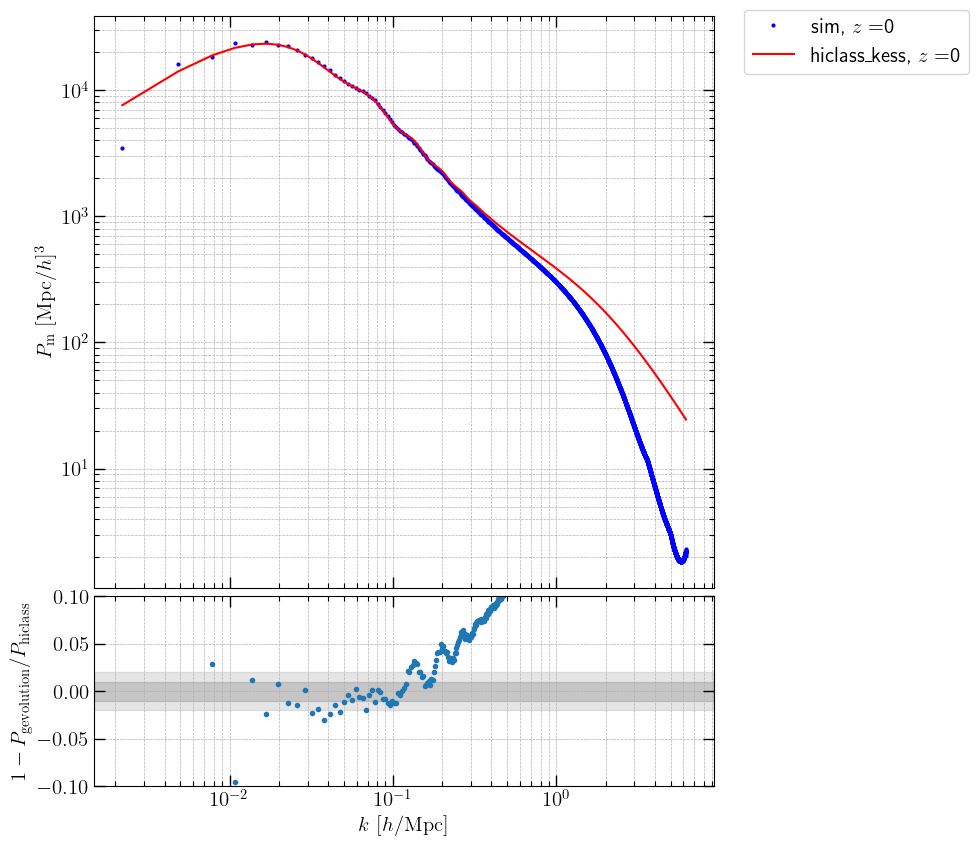

In [10]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}


zind = -1


############################################################################
#                                          hiclass

ax[0].plot(
    kk_sim,
    pk_sim_m,
    "o",
    c="blue",
    label="sim, $z=$" + str(z[zind]),
    markersize=2,
)


ax[0].plot(
    kk_sim,
    Pk_LCDM[zind],
    "-",
    c="red",
    label="hiclass_kess, $z=$" + str(z[zind]),
    markersize=12,
)


ax[1].plot(
    kk,
    1-pk_sim_m/np.array(Pk_LCDM[zind]),"o",
#     c=c[zind],
    label="hiclass, $z=$" + str(z[zind]),
    markersize=3
)

# ax[1].errorbar(
#     kk_sim,
#     1 - np.array(norm_nyq * pk_matter_kgb[zind]) / Pk_kgb[0],
#     yerr=norm_nyq *np.array(error_pk_matter_kgb[zind]) / Pk_kgb[0],
#     fmt="o",
#     elinewidth=1,
#     ms=2,
# )

ax[1].axhspan(-0.01, 0.01, color="gray", alpha=0.3, label="1% region")
ax[1].axhspan(-0.02, 0.02, color="gray", alpha=0.2, label="2% region")


#ax[1].set_yscale("symlog", linthresh=0.02)
ax[1].set_ylim(-0.1,0.1)

formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax[1].yaxis.set_major_formatter(formatter)


for i in range(2):
    ax[i].set_xscale("log")

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)

    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$P_\mathrm{m}~ [\mathrm{Mpc}/h]^3$", fontsize=15)
ax[1].set_ylabel(r"$1-P_\mathrm{gevolution}/P_\mathrm{hiclass}$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)


ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)



plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

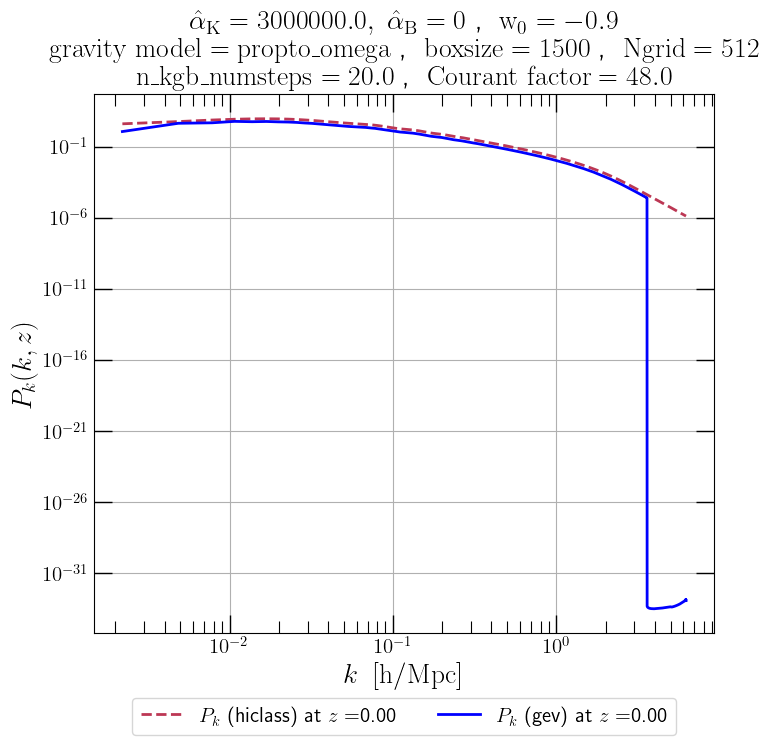

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(8, 7), sharex=True)
plt.subplots_adjust(hspace=0.012, wspace=0.23)

c = sns.color_palette("inferno", len(z)).as_hex()




################################################ plot ###########################################

for zind, zval in list(enumerate(z)):

    ###############################################################################################
    #                                        hiclass KGB

    axs.plot(
        kk,
        pk_delta_smg_hi[zind],
        linewidth=2.0,
        linestyle="--",
        c=c[zind],
        label="$P_k$ (hiclass) at $z = $"
        + "{0:.2f}".format(zval),
        #alpha=0.5,
    )

    axs.plot(
        kk_sim,
        pk_sim_DE,
        linewidth=2.0,
        linestyle="-",
        c='blue',
        label="$P_k$ (gev) at $z = $"
        + "{0:.2f}".format(zval),
        #alpha=0.5,
    )


# axs.axvline(x=0.7, color='r', linestyle='--', linewidth=2)
axs.set_ylabel(r"$P_k(k,z)$", fontsize=20)
axs.set_xlabel(r"$k\,\,\,  \mathrm{[h/Mpc]}$", fontsize=20)
# axs.axvline(x = 1.1, c = 'blue', linestyle = '--')


axs.tick_params("both", length=13, width=1, which="major")
axs.tick_params("both", length=8.5, width=0.8, which="minor")
axs.tick_params(direction="in", which="major", labelsize=15)
axs.tick_params(direction="in", which="minor")
axs.yaxis.set_ticks_position("both")
axs.xaxis.set_ticks_position("both")
axs.set_xscale("log")
axs.set_yscale("log")

axs.grid()
# axs.legend(fontsize = 15)
axs.legend(
    fontsize=15,  # Font size
    loc="upper center",
    #bbox_to_anchor=(1.25, 1.02),
    bbox_to_anchor=(.5, -.1),
    ncol=2,
)


# axs.set_ylim(1.25,1.30)

gravity_model_latex = parser.get("top", "gravity_model")
gravity_model_latex = gravity_model.replace("_", r"\_")

axs.set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$"
    + "~,~~"
    rf"$\mathrm{{w_0}} = \mathrm{{{w_kgb}}}$"
    + "\n"
    + rf"$\mathrm{{gravity\ model}} = \mathrm{{{gravity_model_latex}}}$"
    + "~,~~"
    rf"$\mathrm{{boxsize}} = \mathrm{{{boxsize}}}$" + "~,~~"
    rf"$\mathrm{{Ngrid}} = \mathrm{{{Ngrid}}}$"
    + "\n"
    + rf"$\mathrm{{n\_kgb\_numsteps}} = \mathrm{{{n_kgb_numsteps}}}$"
    + "~,~~"
    rf"$\mathrm{{Courant~factor}} = \mathrm{{{Courant_factor}}}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}